<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/drive/MyDrive/FastCampus/Medical/Part 2/실습/07. Histology Image weakly supervised Learning segmentation/gdc-client_v1.6.1_Ubuntu_x64.zip'

Archive:  /content/drive/MyDrive/FastCampus/Medical/Part 2/실습/07. Histology Image weakly supervised Learning segmentation/gdc-client_v1.6.1_Ubuntu_x64.zip
 extracting: gdc-client              


In [ ]:
!./gdc-client download -m '/content/drive/MyDrive/FastCampus/Medical/Part 2/실습/07. Histology Image weakly supervised Learning segmentation/gdc_manifest_20220410_013342.txt'

100% [#################################################################] Time:  0:00:16   6.8 MiB/s 
Successfully downloaded: 1


In [ ]:
!unzip '/content/drive/MyDrive/FastCampus/Medical/Part 2/실습/07. Histology Image weakly supervised Learning segmentation/pytorch_grad_cam.zip'

Archive:  /content/drive/MyDrive/FastCampus/Medical/Part 2/실습/07. Histology Image weakly supervised Learning segmentation/pytorch_grad_cam.zip
   creating: pytorch_grad_cam/
replace __MACOSX/._pytorch_grad_cam? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._pytorch_grad_cam  
  inflating: pytorch_grad_cam/grad_cam_plusplus.py  
replace __MACOSX/pytorch_grad_cam/._grad_cam_plusplus.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/pytorch_grad_cam/._grad_cam_plusplus.py  
  inflating: pytorch_grad_cam/guided_backprop.py  
  inflating: pytorch_grad_cam/.DS_Store  
  inflating: __MACOSX/pytorch_grad_cam/._.DS_Store  
  inflating: pytorch_grad_cam/eigen_grad_cam.py  
  inflating: pytorch_grad_cam/fullgrad_cam.py  
  inflating: pytorch_grad_cam/activations_and_gradients.py  
  inflating: __MACOSX/pytorch_grad_cam/._activations_and_gradients.py  
  inflating: pytorch_grad_cam/__init__.py  
  inflating: __MACOSX/pytorch_grad_cam/.___init__.py  
  inflating

In [ ]:
# Install ttach(Image Test Time Augmentation with PyTorch)
!pip install ttach

# Install python-openslide
!apt update && apt install -y openslide-tools
!pip install openslide-python

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,566 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,398 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy

In [ ]:
from PIL import Image
import openslide
import numpy as np

In [ ]:
# openslide로 whole slide image(WSI) 불러오기
# TCGA-COAD
slide_mask = openslide.open_slide("/content/drive/MyDrive/FastCampus/Medical/Part 2/실습/07. Histology Image weakly supervised Learning segmentation/ed500fa9-70b1-4d52-9e73-d8d512448901/TCGA-AD-6901-01Z-00-DX1.0a69c0b5-6238-4c1a-bbbd-ea743bf6fc98.svs")


top_left = (6000, 6000) # top left 픽셀 값
level_dim = slide_mask.level_dimensions # WSI levels
for i, dim in enumerate(level_dim):
    print(f"Level{i} 픽셀 크기: {dim}")

vis_level = 0 # WSI level (0 - 가장 큰 magnification)
region_size = level_dim[vis_level] # 해당 level에서 전체 픽셀 크기

Level0 픽셀 크기: (35492, 32395)
Level1 픽셀 크기: (8873, 8098)
Level2 픽셀 크기: (2218, 2024)


In [ ]:
# 자를 이미지 크기

crop_size = (224 * 3, 224 * 3)

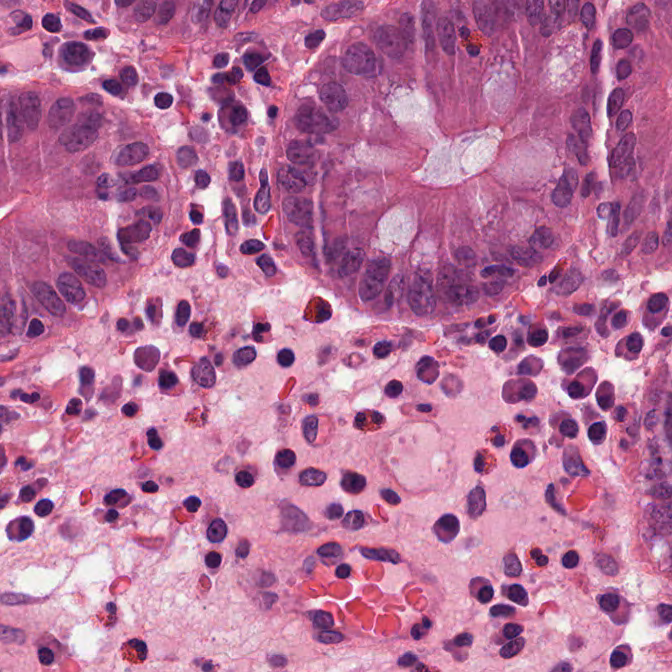

In [ ]:
# vis_level 0 (20x magnification)

slide_mask.read_region(top_left, 0, crop_size).convert("RGB")

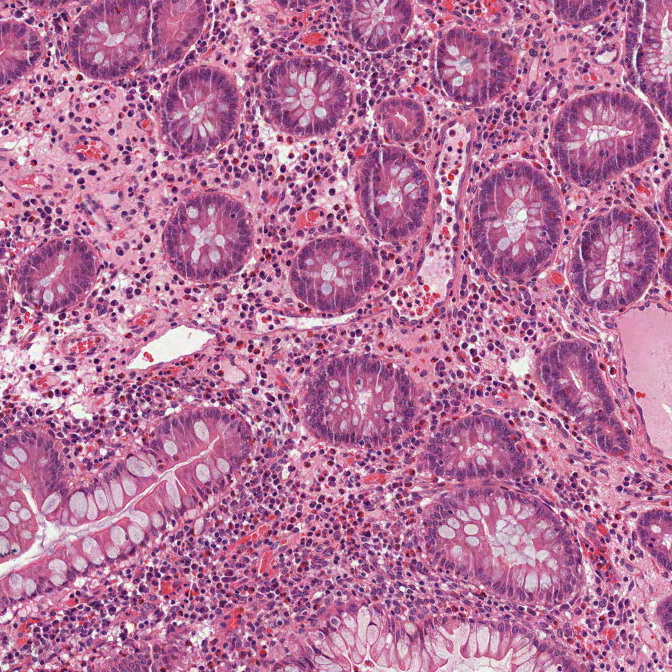

In [ ]:
# vis_level 1 (10x magnification)

slide_mask.read_region(top_left, 1, crop_size)

In [ ]:
# WSI 자르기

top_left = (5000, 5000)
crop_size = (224 * 18, 224 * 18)

In [ ]:
# WSI 이미지 잘라서 가져오기

test_im2arr = np.array(slide_mask.read_region(top_left, 0, crop_size).convert("RGB"))

In [ ]:
slide_x_size = test_im2arr.shape[1] # WSI의 열 차원 크기
slide_y_size = test_im2arr.shape[0] # WSI의 행 차원 크기

# 추출할 패치 사이즈
step_x = 224 # X축(열방향) 사이즈
step_y = 224 # Y축(행방향) 사이즈

# 각 축 별 추출할 패치 개수
num_x = int(slide_x_size/step_x) # X축 방향 개수
num_y = int(slide_y_size/step_y) # Y축 방향 개수
print(f"총 패치 데이터의 개수: {num_x*num_y}")

# WSI를 패치로 나누어 리스트에 저장
image_split_list = []

for y_index in range(0, num_y):
    for x_index in range(0, num_x):
        temp_image = test_im2arr[step_y * y_index : step_y * (y_index + 1), step_x * x_index : step_x * (x_index + 1)]
        image_split_list.append(temp_image)

총 패치 데이터의 개수: 324


In [ ]:
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet50
import torch.nn as nn
from pytorch_grad_cam import GradCAM

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 cuda:0 입니다.


In [ ]:
# data transform 적용하기

image_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(size=224),
        transforms.ToTensor(),

        # data augmentation
        transforms.RandomRotation(90, expand=False),
        transforms.RandomRotation(180, expand=False),
        transforms.RandomRotation(270, expand=False),

        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Dataset 클래스 직접 정의하기

class Image_Array_list_test_Dataset(Dataset):
    """
    슬라이드 패치 이미지를 위한 추상클래스

    torch.utils.data.Dataset 를 상속 받아 오버라이드
    """

    def __init__(self, data, transform=None):
        """
        Args:
            data: 추출한 패치들이 담긴 리스트
            transform: 데이터에 적용될 transform (optinal)
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x

In [ ]:
# 패치 데이터 데이터셋 인스턴스 생성
test_Dataset = Image_Array_list_test_Dataset(image_split_list, transform=image_transforms['valid'])

# 데이터로더 적용
test_dataloader = DataLoader(test_Dataset, batch_size=32)

In [ ]:
print(f"이미지 shape = {list(test_Dataset[0].shape)}")

이미지 shape = [3, 224, 224]


In [ ]:
Classes = ['ADI', 'BAC', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

num_classes = len(Classes)

In [ ]:
# resnet50 모델 불러오기
model = resnet50(pretrained=False)

# 마지막 layer 변경 (2048 -> 1000 => 2048 -> 128 -> num_classes)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, num_classes))

# model device에 올리기
model = model.to(device)

# 미리 학습
model.load_state_dict(torch.load("/content/drive/MyDrive/FastCampus/Medical/Part 2/실습/07. Histology Image weakly supervised Learning segmentation/model.pt"))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
import numpy as np
# 데이터 레이블
Classes = ['ADI', 'BAC', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

num_classes = len(Classes)

In [ ]:
def plot_pixel_color(mask_color):
    """픽셀 색 보여주기
    """

    # from skimage import io
    import matplotlib.pyplot as plt

    num = mask_color.shape[0]

    ind = np.arange(num).reshape(1,num)

    fig = plt.figure(figsize=(num,2))
    ax = fig.add_subplot(111)
    ax.imshow(mask_color[ind])
    ax.set_yticks([])
    ax.set_xticks(range(num))
    ax.set_xticklabels(Classes)

    plt.show()

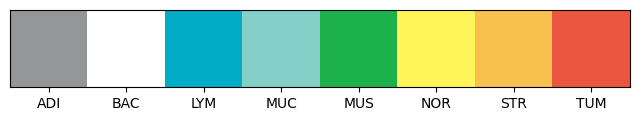

In [ ]:
# 각 클래스 별로 masking할 색 정하기

image_mask_color =  np.array([
    [148, 150, 151],  # ADI
    [255, 255, 255],  # BAC
    # [187, 128, 183],
    [0,   172, 198],  # LYM
    [132, 207, 199], # MUC
    [29,  177,  76], # MUS
    [255, 244,  89], # NOR
    [247, 192,  79], # STR
    [235,  86,  64]   # TUM
])

image_mask_color = image_mask_color / 255


plot_pixel_color(image_mask_color)

In [ ]:
def apply_mask_image(image, color, alpha=0.5):
    """픽셀별로 mask 적용하기

    Args:
        image: 각 픽셀 값
        color: 클래스 별 masking color 값을 행으로 하는 행렬 (8x3)
        alpha: 투명도 [0,1]

    Returns:
        image에 mask 입힌 이미지 반환
    """

    new_image = (1 - alpha) * image + alpha * image_mask_color[color] * 255

    return new_image

In [ ]:
def image_crop_list_to_total_image(image_array_list, step_y, step_x, step_num_y, step_num_x):
    """masking한 패치 이미지를 다시 전체 슬라이드 이미지로 합치기

    Args:
        image_array_list:
        step_y: 패치 이미지 Y축 사이즈
        step_x: 패치 이미지 X축 사이즈
        step_num_y: Y축 방향 패치 이미지 개수
        step_num_x: X축 방향 패치 이미지 개수

    Returns:
        합쳐진 전체 슬라이드 이미지
    """

    if len(image_array_list) != step_num_y * step_num_x:
        raise Exception('length of image_Array_list is not same to step_num_y X step_num_X')

    # 전체 슬라이드 이미지와 같은 크기의 영행렬 생성
    out_image_array = np.zeros((step_y * step_num_y, step_x * step_num_x, 3), dtype = np.uint8)

    # masking 된 패치 이미지로 이루어진 전체 슬라이드 이미지 생성
    cnt = 0
    for y_index in range(0, step_num_y):
        for x_index in range(0, step_num_x):
            out_image_array[step_y * y_index : step_y * (y_index + 1), step_x * x_index : step_x * (x_index + 1)] = image_array_list[cnt]
            cnt += 1

    return out_image_array

In [ ]:
label_list = []

# 학습한 모델을 이용해 inference
for inputs in tqdm(test_dataloader):

    inputs = inputs.to(device, non_blocking=True) # [batch_size, 3, 224, 224]
    outputs = model(inputs) # [batch_size x num_classes(8)]
    outputs = outputs.cpu().detach().numpy()
    label_list.extend(np.argmax(outputs, 1).tolist()) # inference한 클래스 리스트에 담기

# 패치 별 mask 오버레이(overlay)
out_result_image_list = []
for index, seg_label_image in enumerate(tqdm(label_list)):
    new_image = apply_mask_image(image_split_list[index], label_list[index])
    out_result_image_list.append(new_image)

100%|██████████| 324/324 [00:00<00:00, 876.75it/s]


In [ ]:
# 패치 이미지 하나로 병합
merge_image = image_crop_list_to_total_image(out_result_image_list, step_x, step_y, num_y, num_x)
test_merge_image = Image.fromarray(merge_image)

# 시각화를 위해 사이즈 줄이기
test_merge_image = test_merge_image.resize((int(test_merge_image.width / 6), int(test_merge_image.height / 6)))

In [ ]:
# model 마지막 층 가져오기
target_layers = [model.layer4[-1]]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

In [ ]:
# out_cams = []

cnt = 0

for inputs in tqdm(test_dataloader):

    gradcam_8_class_pred_weight_all_class_batch = np.zeros((8, inputs.shape[0], inputs.shape[2], inputs.shape[3])) # [8 x batch_size x 224 x 224]

    inputs = inputs.to(device) # [batch_size, 3, 224, 224]
    outputs = model(inputs) # [batch_size x num_classes(8)]

    for i in range(num_classes):
        gradcam_8_class_pred_weight_one_class_batch = np.zeros((inputs.shape[0], inputs.shape[2], inputs.shape[3])) # [batch_size x 224 x 224]

        class_score = outputs[:, i].cpu().detach().numpy() # [batch_size]

        grayscale_cam = cam(input_tensor=inputs, target_category=i) # GradCAM 적용 [batch_size x 224 x 224]

        for batch_index, score in enumerate(class_score):
            gradcam_8_class_pred_weight_one_class_batch[batch_index, : , :] = grayscale_cam[batch_index, :, :] * score # cam output x classification score


        gradcam_8_class_pred_weight_all_class_batch[i, :, : , :] = gradcam_8_class_pred_weight_one_class_batch

        gradcam_8_class_pred_weight_all_class_batch = np.float16(gradcam_8_class_pred_weight_all_class_batch)

    if cnt == 0:
        all_gradcam = gradcam_8_class_pred_weight_all_class_batch

    else:
        all_gradcam = np.concatenate((all_gradcam, gradcam_8_class_pred_weight_all_class_batch), axis=1)

    # all_gradcam: [num_classes(8), num_patches(900), 224, 224]

    cnt += 1

100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


In [ ]:
# class 차원에 대해 argmax
argmax_result_matrix = np.argmax(all_gradcam, axis=0) # [8 x num_patches(900) x 224 x 224] -> [num_patches(900) x 224 x 224]


In [ ]:
# class 별 개수 구하기
unique, counts = np.unique(argmax_result_matrix, return_counts=True)

Text(0, 0.5, 'Counts')

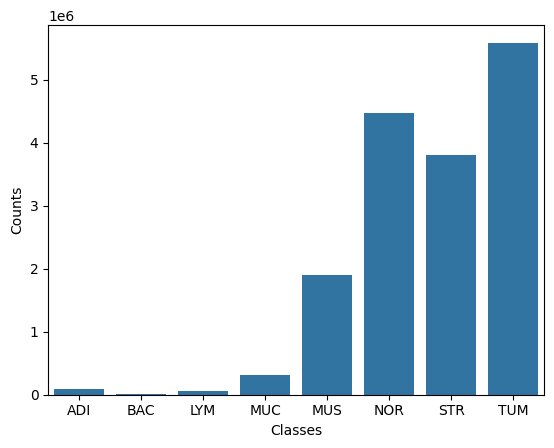

In [ ]:
# 픽셀 별 class 분포

import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.subplot()
sns.barplot(counts)
ax.set_xticks(unique)
ax.set_xticklabels(Classes)
plt.xlabel("Classes")
plt.ylabel("Counts")

In [ ]:
component_rate = dict(zip(Classes, counts))

# TSR 확인
component_rate['STR'] / (component_rate['STR'] + component_rate['TUM'])

0.4051078259744845

In [ ]:
def apply_mask_pixel_for_multi_processing(argmax_result_matrix, original_image_matrix):
    """패치 이미지의 모든 픽셀 마다 미리 지정한 클래스 별 색으로 masking 하기

    Args:
        argmax_result_matrix: GradCAM으로 픽셀 별로 class 할당한 결과 매트릭스. 아래 옵션 중 하나의 형태
            1. (900 x 224 x 224)
            2. (6720 x 6720)

        original_image_matrix: 아래 옵션 중 하나
            1. 패치 이미지가 담긴 리스트 ([224 x 224 x 3] * 900)
            2. WSI (numpy,ndarray) (6720, 6720, 3)

    Returns:
        masking 된 패치 이미지를 담은 리스트 ([224 x 224 x 3] * 900)
    """

    if isinstance(original_image_matrix, list):
        if len(argmax_result_matrix) != len(original_image_matrix):
            raise Exception("original image와 argmax result의 크기가 다릅니다.")

        out_result_image_list = []

        for index, seg_label_image in enumerate(tqdm(argmax_result_matrix)):
            new_image = np.zeros((224, 224, 3))

            for width in range(224):
                for height in range(224):
                    new_image[width, height] = apply_mask_image(original_image_matrix[index][width, height], seg_label_image[width, height])

            out_result_image_list.append(new_image)

        return out_result_image_list

    elif isinstance(original_image_matrix, np.ndarray):
        if original_image_matrix.shape[:2] != argmax_result_matrix.shape:
            raise Exception("original image와 argmax result의 shape을 확인해주세요.")

        dim_y = original_image_matrix.shape[0]
        dim_x = original_image_matrix.shape[1]

        new_image = np.zeros((dim_y, dim_x, 3))

        for width in range(dim_y):
            for height in range(dim_x):
                new_image[width, height] = apply_mask_image(original_image_matrix[width, height], argmax_result_matrix[width, height])

        return new_image

    else:
        raise Exception("original_image_matrix의 형이 적절하지 않습니다.")

In [ ]:
# 병렬 처리를 위한 라이브러리
import multiprocessing

num_cpu = multiprocessing.cpu_count()
print(f"현재 이용 가능한 CPU 개수: {num_cpu}")

현재 이용 가능한 CPU 개수: 8


In [ ]:
def do_multi_n_merge(argmax_result_matrix, original_image_matrix, num_cores):
    """지정된 코어 개수 만큼 데이터 나누어서 병렬 처리 진행 후 결과 병합

    Args:
        argmax_result_matrix: 픽셀 별 class 값을 가지는 매트릭스
        num_cores: 병렬 처리에 사용할 코어 개수

    Returns:
        병렬 처리한 결과가 담긴 리스트
    """

    # 전체 패치 개수를 코어 개수로 나누기
    step_data = argmax_result_matrix.shape[0] // num_cores

    # 병렬 처리를 위해 리스트에 데이터 나누어 담기
    split_argmax_result_matrix = [] # 픽셀 별 class 값을 나누어 담을 리스트
    split_original_image_matrix = [] # 전체 패치 이미지를 나누어 담을 리스트

    for i in range(0, num_cores):
        if i == num_cores - 1:
            split_argmax_result_matrix.append(argmax_result_matrix[i * step_data:])
            split_original_image_matrix.append(original_image_matrix[i * step_data:])
        else:
            split_argmax_result_matrix.append(argmax_result_matrix[i * step_data : (i + 1) * step_data])
            split_original_image_matrix.append(original_image_matrix[i * step_data : (i + 1) * step_data])

    # 병렬 처리 진행
    pool = multiprocessing.Pool(processes = num_cores)
    test = pool.starmap(apply_mask_pixel_for_multi_processing, zip(split_argmax_result_matrix, split_original_image_matrix))

    # 병렬 처리한 결과 병합
    test_merge = []

    for multi_result in test:
        test_merge.extend(multi_result)

    return test_merge

In [ ]:
test_merge = do_multi_n_merge(argmax_result_matrix, image_split_list, num_cpu)

100%|██████████| 44/44 [00:25<00:00,  1.71it/s]


In [ ]:
# 패치 이미지 하나로 병합
merge_image = image_crop_list_to_total_image(test_merge, step_x, step_y, num_y, num_x)
test_merge_image = Image.fromarray(merge_image)

# 시각화를 위해 사이즈 줄이기
test_merge_image = test_merge_image.resize((int(test_merge_image.width / 6), int(test_merge_image.height / 6)))